In [32]:
pip install pennylane

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
#!pip install pennylane
import time
import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

torch.manual_seed(42)
np.random.seed(42)

# Plotting
import matplotlib.pyplot as plt

# OpenMP: number of parallel threads.
os.environ["OMP_NUM_THREADS"] = "5"
from PIL import Image
from torchsummary import summary
plt.ion()
import pandas as pd
import seaborn as sns

In [34]:
!pip install pennylane

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
#!pip install qulacs-gpu

In [36]:
pip install --upgrade torchvision==0.12

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
pip install pennylane-lightning[gpu]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
n_qubits =4          # Number of qubits
step = 0.0001              # Learning rate
batch_size =15           # Number of samples for each training step
num_epochs =15          # Number of training epochs
q_depth =1               # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.001              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

In [40]:
dev = qml.device("lightning.qubit", wires=n_qubits)

In [41]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [42]:
data_transforms = {
    'train': transforms.Compose([


        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.3854, 0.3854, 0.3854], [0.4143, 0.4143, 0.4143]),


    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.3854, 0.3854, 0.3854], [0.4143, 0.4143, 0.4143]),


    ]),
    'test': transforms.Compose([

         transforms.Resize((224,224)),
         transforms.ToTensor(),
         transforms.Normalize([0.3854, 0.3854, 0.3854], [0.4143, 0.4143, 0.4143]),

    ]),
}

data_dir = '/content/drive/MyDrive/Data1'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = image_datasets['train'].classes


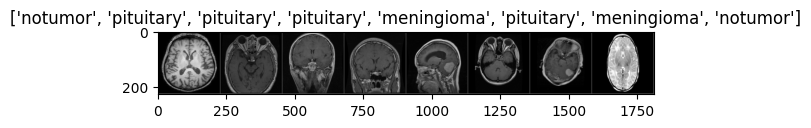

In [43]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.3854, 0.3854, 0.3854])
    std = np.array([0.4143, 0.4143, 0.4143])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [44]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    qml.CNOT(wires=[0, 1])
    for i in range(0, nqubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])

'def entangling_layer(nqubits):\n    qml.CNOT(wires=[0, 1])\n    for i in range(0, nqubits - 1, 2):  \n        qml.CNOT(wires=[i, i + 1])\n    for i in range(1, nqubits - 1, 2):\n        qml.CNOT(wires=[i, i + 1])'

In [45]:
@qml.qnode(dev,diff_method='parameter-shift',interface="torch")
def quantum_net(q_input_features, q_weights_flat):


    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        #entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)


In [46]:
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.fc1 = nn.Linear(4096,4)
        self.relu=nn.ReLU()
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits,4)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dime(nsion from 40964
        pre_out= self.fc1(input_features)
        #q_in = torch.tanh(pre_out) * np.pi / 2.0
        q_in=self.relu(pre_out)

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

In [47]:
model_hybrid = torchvision.models.vgg16(pretrained=True)

for param in model_hybrid.parameters():
    param.requires_grad = False




# Notice that model_hybrid.fc is the last layer of alexnet
model_hybrid.classifier[6] = DressedQuantumNet()


# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.


In [48]:
model_hybrid

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [49]:
criterion = nn.CrossEntropyLoss().to(device)

In [50]:
optimizer_hybrid = optim.Adam(model_hybrid.parameters(), lr=0.0001)

In [51]:
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler
)

In [52]:
tloss=[]
vloss=[]
tacc=[]
vacc=[]

def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs).to(device)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                tloss.append(epoch_loss)
                tacc.append(epoch_acc)
            if phase == 'val':
                vloss.append(epoch_loss)
                vacc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [53]:
model_hybrid = train_model(
    model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=15
)

Epoch 0/14
----------
train Loss: 1.2443 Acc: 0.4636
val Loss: 1.1641 Acc: 0.4975

Epoch 1/14
----------
train Loss: 1.1501 Acc: 0.4951
val Loss: 1.0950 Acc: 0.6887

Epoch 2/14
----------
train Loss: 1.0796 Acc: 0.6498
val Loss: 1.0180 Acc: 0.6859

Epoch 3/14
----------
train Loss: 1.0051 Acc: 0.6976
val Loss: 0.9436 Acc: 0.7235

Epoch 4/14
----------
train Loss: 0.9391 Acc: 0.7167
val Loss: 0.8717 Acc: 0.7370

Epoch 5/14
----------
train Loss: 0.8721 Acc: 0.7420
val Loss: 0.8186 Acc: 0.7598

Epoch 6/14
----------
train Loss: 0.8086 Acc: 0.7810
val Loss: 0.7457 Acc: 0.8387

Epoch 7/14
----------
train Loss: 0.7485 Acc: 0.8223
val Loss: 0.6912 Acc: 0.8607

Epoch 8/14
----------
train Loss: 0.6973 Acc: 0.8415
val Loss: 0.6537 Acc: 0.8657

Epoch 9/14
----------
train Loss: 0.6499 Acc: 0.8443
val Loss: 0.6010 Acc: 0.8714

Epoch 10/14
----------
train Loss: 0.6257 Acc: 0.8549
val Loss: 0.5890 Acc: 0.8770

Epoch 11/14
----------
train Loss: 0.6205 Acc: 0.8510
val Loss: 0.5838 Acc: 0.8785

Ep

In [54]:
torch.save(model_hybrid,"modelqne221.pth")

In [56]:
tacc= [tensor.tolist() for tensor in tacc]
vacc= [tensor.tolist() for tensor in vacc]


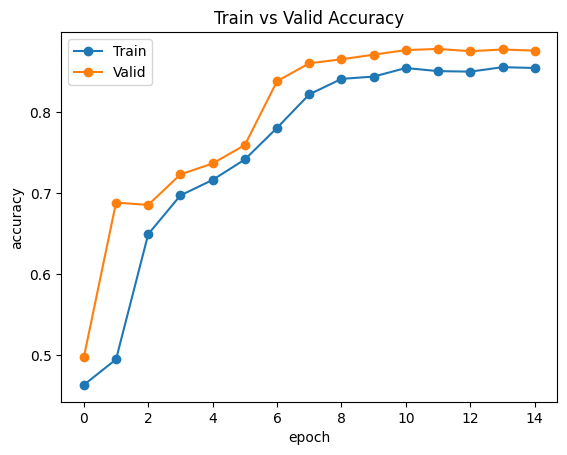

In [57]:

plt.plot(tacc,'-o')
plt.plot(vacc,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

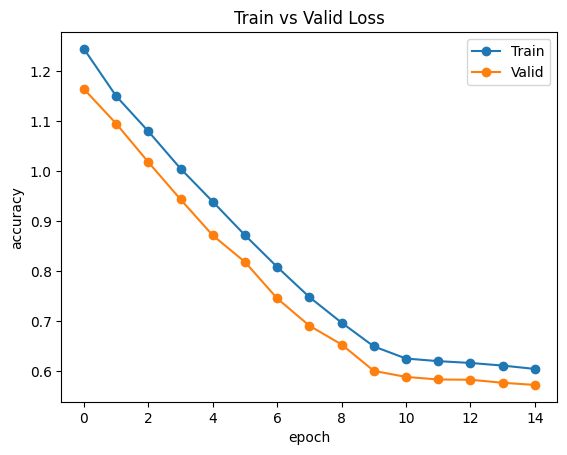

In [58]:
plt.plot(tloss,'-o')
plt.plot(vloss,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Loss')

plt.show()

In [59]:
testloader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=10, shuffle=True, num_workers=4)
correct, total = 0, 0
correct_count, all_count = 0, 0
for images,labels in testloader:
  for i in range(len(labels)):
    if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
    img = images[i].view(1,3, 224, 224)
    with torch.no_grad():
        logps = model_hybrid(img)


    ps = torch.exp(logps)
    probab = list(ps.cpu()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.cpu()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  def __init__(self, loader):


Number Of Images Tested = 705

Model Accuracy = 0.8822695035460993


In [60]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

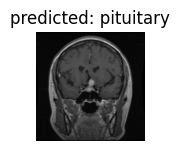

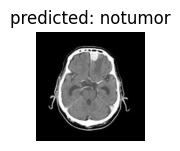

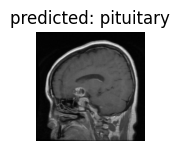

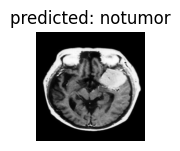

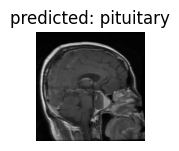

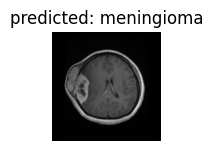

In [61]:
visualize_model(model_hybrid)

In [62]:
def predict(model, test_image_name):
    '''
    Function to predict the class of a single test image
    Parameters
        :param model: Model to test
        :param test_image_name: Test image

    '''
    transform = data_transforms['val']

    test_image = Image.open(test_image_name).convert('RGB')
    test_image_tensor = transform(test_image)
    plt.imshow(test_image)



    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1,3, 224, 224)

    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
         # Reverse the log function in our output
        output = torch.exp(out)

    # Get the top predicted class, and the output percentage for
    # that class
    probs, classes = output.topk(1, dim=1)
    if classes.item()==0 :
        a="Covid"
    elif classes.item()==1 :
        a="Pneumonia"
    else:
        a="Normal"

    return probs.item(),a

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  def __init__(self, loader):


''

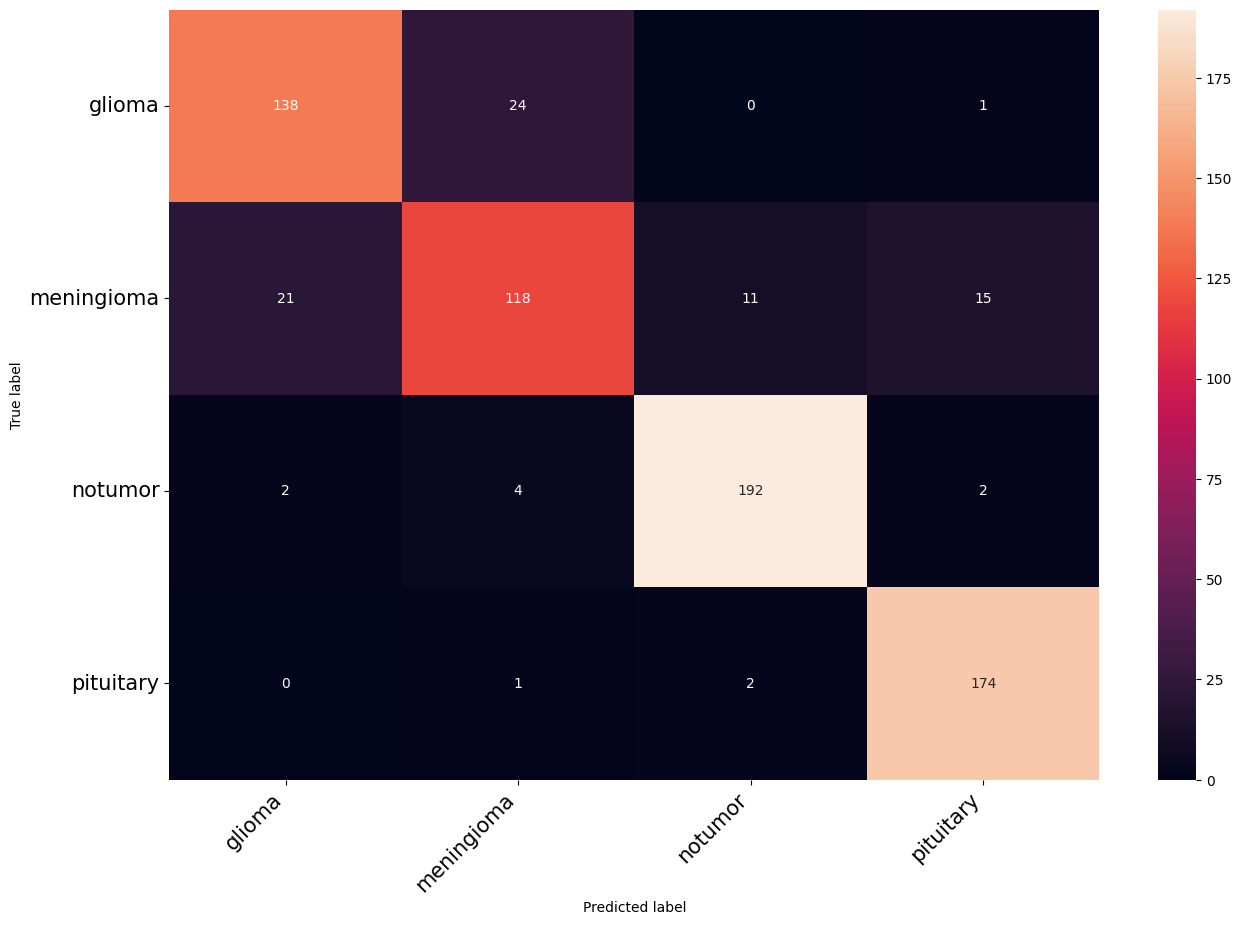

In [64]:
test_loader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=10, shuffle=True, num_workers=4)
nb_classes = 4
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_hybrid(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(15,10))

#class_names = list(label2class.values())
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
;